# A Basic EEG classifier with Inception
## Goals
1. Collect Corvo data from one user, perhaps from just one long session so the electrodes are in the same position.
2. Break data into short epochs (2s?)
3. Convert each epoch into a spectrogram (sounds like we can just convert it into a matrix  instead of an actual jpeg)
4. Label each epoch with its associated current Corvo performance score
5. Feed to Inception (I have a big GPU that might help here) https://www.youtube.com/watch?v=cSKfRcEDGUs
6. Test

## Getting data to retrain Inception

In [64]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from tensorflow.contrib import learn

EPOCH_LENGTH = 880
VARIANCE_THRESHOLD = 400

In [72]:
# Data has been collected, let's import it

open_data = pd.read_csv("../Muse Data/DanoNewRawOpen.csv", header=0, index_col=False)
closed_data = pd.read_csv("../Muse Data/DanoNewRawClosed.csv", header=0, index_col=False)

In [73]:
# Drop difficulty, timestamp, and performance columns since we're not using them

open_data = open_data.drop(['Difficulty', 'Performance', 'Timestamp (ms)'], axis=1)
closed_data = closed_data.drop(['Difficulty', 'Performance', 'Timestamp (ms)'], axis=1)


# Prune rows from tail of datasets so that they are all divisible by 440 (the desired size of our epochs)

open_overflow = open_data.shape[0] % EPOCH_LENGTH
open_data = open_data[0:-open_overflow]
closed_overflow = closed_data.shape[0] % EPOCH_LENGTH
closed_data = closed_data[0:-closed_overflow]

In [74]:
# Split DataFrames into many different dataframes 440 samples long

split_open_data = np.stack(np.array_split(open_data, EPOCH_LENGTH), axis=1)
split_closed_data = np.stack(np.array_split(closed_data, EPOCH_LENGTH), axis=1)

# Transform data into a 3D pandas Panel ( n epochs x 4 channels x 440 samples )

open_panel = pd.Panel(split_open_data)
closed_panel = pd.Panel(split_closed_data)


closed_panel.describe


<bound method NDFrame.describe of <class 'pandas.core.panel.Panel'>
Dimensions: 7 (items) x 880 (major_axis) x 4 (minor_axis)
Items axis: 0 to 6
Major_axis axis: 0 to 879
Minor_axis axis: 0 to 3>

In [82]:
# Remove epochs with too much variance

def removeNoise(panel):
    for frameIndex in panel:
        for columnIndex in panel[frameIndex]:
            if np.var(panel[frameIndex][columnIndex]) > VARIANCE_THRESHOLD:
                print('variance ', np.var(panel[frameIndex][columnIndex]), ' at electrode ', columnIndex, ' frame ', frameIndex)
                panel = panel.drop(frameIndex)
                break
    return panel

#closed_panel = removeNoise(closed_panel)

#open_panel = removeNoise(open_panel)


<function matplotlib.pyplot.show>

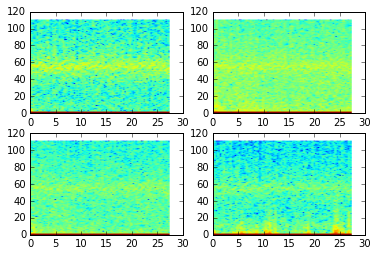

In [83]:
# Let's a take a look at what this kind of data looks like

%matplotlib inline 

plt.figure()

plt.subplot(2,2,1)
plt.specgram(closed_data['Channel 1'], NFFT=256, Fs=220, noverlap=198)

plt.subplot(2,2,2)
plt.specgram(closed_data['Channel 2'], NFFT=256, Fs=220, noverlap=198)

plt.subplot(2,2,3)
plt.specgram(closed_data['Channel 3'], NFFT=256, Fs=220, noverlap=198)

plt.subplot(2,2,4)
plt.specgram(closed_data['Channel 4'], NFFT=256, Fs=220, noverlap=198)

plt.show

<function matplotlib.pyplot.show>

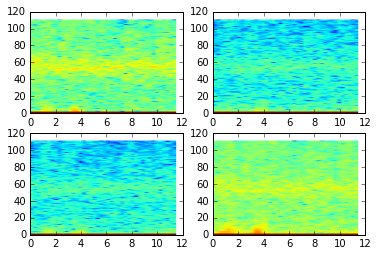

In [84]:
# Let's a take a look at what this kind of data looks like

%matplotlib inline 

plt.figure()

plt.subplot(2,2,1)
plt.specgram(open_data['Channel 1'], NFFT=256, Fs=220, noverlap=198)


plt.subplot(2,2,2)
plt.specgram(open_data['Channel 2'], NFFT=256, Fs=220, noverlap=198)


plt.subplot(2,2,3)
plt.specgram(open_data['Channel 3'], NFFT=256, Fs=220, noverlap=198)

plt.subplot(2,2,4)
plt.specgram(open_data['Channel 4'], NFFT=256, Fs=220, noverlap=198)


plt.show


<function matplotlib.pyplot.show>

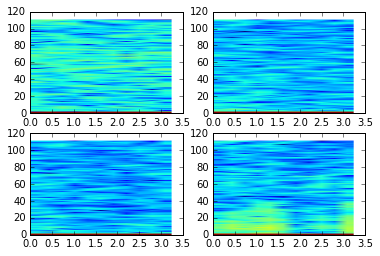

In [85]:
# Let's a take a look at what this kind of data looks like

%matplotlib inline 

plt.figure()

plt.subplot(2,2,1)
plt.specgram(closed_panel[2][0], NFFT=256, Fs=220, noverlap=198)


plt.subplot(2,2,2)
plt.specgram(closed_panel[2][1], NFFT=256, Fs=220, noverlap=198)


plt.subplot(2,2,3)
plt.specgram(closed_panel[2][2], NFFT=256, Fs=220, noverlap=198)


plt.subplot(2,2,4)
plt.specgram(closed_panel[2][3], NFFT=256, Fs=220, noverlap=198)


plt.show

In [12]:
# Plot spectograms of all 4 channels and save them to the local folder

def plotAndSave(frame, filename):
    plt.figure()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplot(2,2,1)
    plt.specgram(frame[0], NFFT=256, Fs=220, noverlap=198)
    plt.ylim(0,55)
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.specgram(frame[1], NFFT=256, Fs=220, noverlap=198)
    plt.ylim(0,55)
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.specgram(frame[2], NFFT=256, Fs=220, noverlap=198)
    plt.ylim(0,55)
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.specgram(frame[3], NFFT=256, Fs=220, noverlap=198)
    plt.ylim(0,55)
    plt.axis('off')
    plt.savefig('%s.jpg' % filename, pad_inches=0, bbox_inches='tight')
    
for frameIndex in open_panel:
    plotAndSave(open_panel[frameIndex], 'open%s' % frameIndex)

for frameIndex in closed_panel:
    plotAndSave(closed_panel[frameIndex], 'closed%s' % frameIndex)
    

/home/dano/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Questions to answer before continuing:
- Do these spectrograms look alright?
- Shouldn't the axis go all the way to 2 if there are 440 samples at 220hz sampling rate?
    - Spectrograms always leave out a little bit of data because the window might not line up to the lenght of the sample perfectly. I've increased the amount of data we get by changing the overlap to 198, which works well with our 220hz sampling rate


## Retraining Inception

1. Outside of this notebook, follow the steps in this tutorial to install Docker and a Tensorflow image https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/#4

2. Copy the images produced by the above scripts into an 'open' and 'closed' folder in a directory in your homedir

3. Run this code to link this example folder to your Docker container
`sudo docker run -it -v /home/$yourname$/tf_files:/examples gcr.io/tensorflow/tensorflow:latest-devel`

4. With docker open and your folder linked, run this script to retrain inception on these new images
```
python tensorflow/examples/image_retraining/retrain.py \
--bottleneck_dir=/home/$yourname$/tf_files/bottlenecks \
--how_many_training_steps 500 \
--model_dir=/home/$yourname$/tf_files/inception \
--output_graph=/home/$yourname$/tf_files/retrained_graph.pb \
--output_labels=/home/$yourname$/tf_files//retrained_labels.tx \
--image_dir /home/$yourname$/tf_files/examples
```




## Testing retraining accuracy

1. Follow the steps in this tutorial and run label_image.py
https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/#4